# Der GfM-Newsletter als Forschungsdatum
## Präsentation zum Vortrag auf der Jahrestagung 2022 der Gesellschaft für Medienwissenschaft (GfM): «Arbeit»
Martin-Luther-Universität Halle-Wittenberg, 28. September – 01. Oktober 2022  
Dr. Dietmar Kammerer, Philipps-Universität Marburg

# ABSTRACT

Der GfM-Newsletter ist ein Forschungsdatum. Das Archiv der Newsletter 2015-2021 enthält rund 1000 Stellenanzeigen. Diese werden nach Datum, Standort, Stellenbeschreibung, Besoldungsgruppe ausgewertet. Auf diese Weise wird die Entwicklung von Stellen in der Medienwissenschaft (im deutschsprachigen Raum) untersuchbar.  
Die Studie ist dabei explorativ und dient der Veranschaulichung der aktuellen Möglichkeiten, aber auch der Grenzen von datenbasierter Forschung im Fach. Alle verwendeten Daten, Tools und Visualisierungen werden über GitHub bereit gestellt. Der Vortrag lädt ein zur Diskussion, welche Einrichtungen (Infrastrukturen, Praktiken) helfen könnten, bestehende Defizite und Desiderate datenbasierter Forschung abzubauen.

Dieses Notebook nimmt Newsletter der Gesellschaft für Medienwissenschaft (GfM) und …
- erstellt ein Archiv der Mails, umbenannt im Format `YYYY-MM-DD.eml`
- sichert PDF-Anhänge (`YYYY-MM-DD_Anhang.pdf`)
- erstellt Tabelle "meldungen.csv" mit sämtlichen Newsletter-Einträgen
- erstellt Tabelle "stellenanzeigen.csv" mit den Volltexten der Stellenanzeigens
- bietet Analysetools an

## Vorbemerkungen
Mein Vortrag heute verfolgt zwei Ziele: **Erstens** will ich vorführen, was es heißt, den Newsletter der GfM als schwach strukturiertes Forschungsdatum zu begreifen, das heißt: Ich will die Frage stellen, wie leicht – oder wie mühsam – es ist, ihn mit einfach verfügbaren Tools und Techniken unter bestimmten Gesichspunkten automatisiert auszuwerten und dabei Forschunsgdaten zu produzieren. 
Es geht mir also weniger um das Ergebnis meiner Auswertung - obwohl ich eine Reihe von Ergebnissen in Form von Diagrammen mitgebracht habe - als um die Methode, den Weg dorthin. Genauer: Um die Hürden, Hindernisse und Stolperfallen auf diesem Weg, aber auch um die Hilfsmittel und Techniken, die einem zur Verfügung stehen.
»Arbeit«, das Thema dieser Jahrestagung, taucht also zweimal, in doppelter gestalt auf: Einmal in Form der **Stellenanzeigen**, die über den Newsletter in Community der Mitglieder der Gesellschaft für Medienwissenschaftler verbreitet werden. Diese Anzeigen versprechen Arbeit in Form eines vertraglich gesicherten Anstellungsverhältnisses an einer wissenschaftlichen Institution – und wir wissen, wie ungesichert, prekär und vorübergehend solche vertraglich gesicherten Verhältnisse sind. Zum anderen geht es um wissenschaftliches Arbeiten, um wissenschaftliche Forschungspraxis, in diesem Fall: um Forschungsdatenpraxis.
Welche Tools stehen dafür zur Verfügung? Welche Möglichekten haben wir im Umgang mit Forschungsdaten, welche Schwierigkeiten bestehen dabei? Insofern ist dieser Vortrag explorativ zu verstehen: Er erkundet ein für unser Fach immer noch relativ neues methodisches Terrain, an einem konkreten Beispiel.

Damit ist auch schon das **zweite Ziel** benannt: Alle Daten, alle Techniken, alle Ergebnisse des Vortrages können eingesehen und nachgenutzt werden - das sind die **FAIR-Prinzipien des Forschungsdatenmanagements**. Auf diese Weise können die Ergebnisse meines kleinen Forschungsprojekts nicht nur nachvollzogen, sondern auch repliziert oder reproduziert werden. Ich werde später vorstellen, welche Ressourcen und Dokumente das genau umfasst und wo diese zu finden sind.

Eine letzte Vorbemerkung, bevor wir zu den Inhalten kommen: Ich präsentiere hier die Ergebnisse eines **kleinen Forschungsprojekts**. Es ist ein Nebenbeiprojekt, eine Fingerübung, kein Schwerpunkt meiner aktuellen Tätigkeit oder Stellenbeschreibung. Mir ist bewußt, dass das dahinter stehende Thema  - die Entwicklung der Stellensituation in Deutschland in der Medienwissenschaft - selbstverständlich noch viel mehr Aufmerksamkeit und Genauigkeit und detaillierte Analysen verdient hätte, was ich aber - im Rahmen meines durch Drittmittel nur temporär gesichert/ungesicherten Arbeitsverhältnisses - nicht leisten konnte. Was ich heute vorstelle, ist in den Abendstunden oder an Wochenenden entstanden.
Andererseits ist ein Ziel des Projekts ja gerade darin, Daten und Ressourcen bereit zu stellen, damit Dritte diese nachnutzen können, um weitere und eigene Fragen zu stellen, eigene Analysen durchzuführen und zu eigenen Ergebnissen zu kommen.


## Datengrundlage
- **GfM-Newsletter** im Zeitraum **vom 30.01.2015 bis 29.04.2022**
- **318 Newsletter**

## Strukturierte Daten im Newsletter
![Newsletter](screenshot_newsletter.png)

# VORBEREITUNG

## Importe

In [1]:
# Diese Zelle importiert die notwendigen Module
import email
from email import policy
from email.parser import BytesParser
from io import BytesIO
import os
import pandas
import matplotlib.pyplot as plt
from pathlib import Path
from pdfminer.high_level import extract_text
import re
import shutil

In [2]:
# Tabellen im Notebook werden auf ganzer Seite und mit Scrollbalken angezeigt
pandas.set_option('display.max_row', None)
pandas.set_option('display.max_colwidth', None)

## Definition der Klassen ‚Mail‘ und ‚Anhang‘

In [3]:
class Mail:
    
    '''definiert Klasse Mail'''
    
    def __init__(self, mailfile):
        
        self.path = Path(mailfile)
        self.msg = email.message_from_binary_file(open(mailfile, 'rb'), policy=policy.default)
        self.date = self.msg['Date'].datetime.isoformat().split('T')[0]
        
        self.volltext = self.get_volltext()
        self.meldungen = self.get_meldungen()
        
    def __repr__(self):
        return f'{self.volltext}'
    
    def get_volltext(self):
        return self.msg.get_body(preferencelist=('plain')).get_content()        

    def get_meldungen(self):
        records = [{'Datum': self.date, 'Meldung': re.sub('\(\d+\)','', line).strip()} \
                   for line in re.findall('\(\d+\)\s*\n?.*', self.volltext)]
        df = pandas.DataFrame.from_dict(records)
        df.Datum = pandas.to_datetime(df.Datum)
        return df
    

In [4]:
class Anhang:

    '''definiert Klasse Anhang'''

    def __init__(self, mailfile):
        
        self.path = Path(mailfile)
        self.msg = email.message_from_binary_file(open(mailfile, 'rb'), policy=policy.default)
        self.date = self.msg['Date'].datetime.isoformat().split('T')[0]
        self.volltext = self.read_attachment()
        self.anzeigen = self.get_stellenanzeigen()
    
    def __repr__(self):
        return self.volltext[:150]
    
    def read_attachment(self):
        for file in self.msg.iter_attachments():
            if "Newsletter" in file.get_filename():
                try:
                    volltext = extract_text(BytesIO(file.get_payload(decode=True))).strip()
                    return volltext

                except:
                    print("Kann Anhang nicht auslesen.")
                    return None

    def get_stellenanzeigen(self):
        anzeigen = re.split('\(\d+\)\s+Stellenauss?chreibung:?\s+', self.volltext)

        if len(anzeigen) > 1:
            records = [{'Datum': self.date, 'Stellenanzeige': anzeige.strip()} for anzeige in anzeigen[1:]]
            df = pandas.DataFrame.from_dict(records)
            df.Datum = pandas.to_datetime(df.Datum)
            return df

        else:
            return None
        
    def save_as_pdf(self, outfolder='.'):    # save attachment as PDF
        for file in self.msg.iter_attachments():
            if "Newsletter" in file.get_filename():
                fo = Path(outfolder, f'{self.date}_anhang.pdf')
                try:
                    fo.write_bytes(file.get_payload(decode=True))
                except:
                    print("Kann Anhang nicht speichern")
                    return None

# I. DATENARCHIV ERSTELLEN

## Umgebungsvariablen festlegen

In [5]:
# In dieser Zelle werden u.a. die Variablen für In- und Output festgelegt
infolder = './daten/archiv/' # Pfad zum Archiv der Newsletter-Mails, ggf. anpassen
outfolder = './out'    

infolder = Path(infolder)   # Materialordner
outfolder = Path(outfolder) # hier wird der Output gespeichert
Path.mkdir(outfolder, exist_ok = True) # bestehender Ordner wird nicht überschrieben

count = len(os.listdir(infolder)) # Anzahl Dateien in Archiv

meldungen = pandas.DataFrame() # legt leeren Dataframe an
stellenanzeigen_volltext = pandas.DataFrame() # legt leeren Dataframe an

## DataFrame "Meldungen" wird erstellt

In [6]:
# Diese Zelle extrahiert alle Meldungen aus den Mails
# Ergebnis wird unter meldungen.csv gespeichert

for file in infolder.glob('*.eml'):
    mail = Mail(file)
    meldungen = pandas.concat([meldungen, mail.meldungen], ignore_index=True)

meldungen = meldungen.sort_values(by='Datum', ignore_index=True) # sortiert Meldungen nach Datum

fo = Path(outfolder, 'meldungen.csv')
meldungen.to_csv(fo, index=False, encoding='utf8')

Diese Zelle sichert alle Mails als `YYYY-MM-DD.eml` und alle Anhänge als `YYYY-MM-DD_anhang.pdf`.  
Die Volltexte der Stellenanzeigen wird als `stellenanzeigen_volltext.csv` gesichert.

In [ ]:
# Diese Zelle sichert alle Mails als `YYYY-MM-DD.eml`
# und alle Anhänge als `YYYY-MM-DD_anhang.pdf`
# Die Volltexte der Stellenanzeigen wird als 'stellenanzeigen_volltext.csv' gesichert.

for n, file in enumerate(infolder.glob('*.eml')):
    
    mail = Mail(file)
    anhang = Anhang(file)
    
    print(f'Verarbeite Newsletter vom {mail.date}. Mail {n+1} von {count-1}')
    
    fo = Path(outfolder, f'{mail.date}.eml')
    shutil.copy(file, fo) # sichere Mail als Kopie, umbenannt in YYYY-MM-DD.eml
    
    anhang.save_to_pdf(outfolder)
    
    meldungen = pandas.concat([meldungen, mail.meldungen], ignore_index=True)
    
    stellenanzeigen_volltext = pandas.concat([stellenanzeigen_volltext, anhang.anzeigen], ignore_index=True)
    
# Volltexte aller Stelenanzeigen sichern
fo = Path(outfolder, 'stellenanzeigen_volltext.csv')
stellenanzeigen_volltext.to_csv(fo, index=False, encoding='utf8')


# II. DATEN AUFBEREITEN

In [7]:
# Falls das Archiv bereits besteht, lädt die Zelle die Tabelle 'meldungen.csv' in ein DataFrame
meldungen = pandas.read_csv('out/meldungen.csv')
meldungen.Datum = pandas.to_datetime(meldungen.Datum)

## Stellenanzeigen filtern
Filter für Stellenanzeigen in Meldungen  
Suchmaske (Regex): `'Stellenaus.*?:\s`

In [8]:
# filtert Stellenanzeigen aus allen Meldungen 
job_pattern = 'Stellenaus.*?:\s'
stellenanzeigen = meldungen.loc[meldungen.Meldung.str.contains(job_pattern), :]
stellenanzeigen = stellenanzeigen.sort_values(by='Datum', ignore_index=True)
stellenanzeigen.Meldung.replace(to_replace=job_pattern, value='', regex=True, inplace=True)

In [9]:
stellenanzeigen

,Datum,Meldung
0,2015-01-30,Wissenschaftliche/r Mitarbeiter/in an der Fakultät Medien der Bauhaus-Universität Weimar
1,2015-01-30,Direktor/in des Internationalen Forschungszentrums Kulturwissenschaften in Wien
2,2015-01-30,Direktor Professur für Digital Humanities an der Universität Graz
3,2015-02-05,"Wissenschaftliche/r Mitarbeiter/in am Graduiertenkolleg ""Automatismen - Kulturtechniken zur Reduzierung von Komplexität"""
4,2015-02-05,Postdoctoral Fellow at the Department of Media Studies at Stockholm University
5,2015-02-05,8 Assistant/Associate Professors in Media Studies at Utrecht University
6,2015-02-13,Volontär/in für Lektorat (Schwerpunkt filmwissenschaftliche Titel) und Werbung/PR bei etk
7,2015-02-13,Wissenschaftliche/r Mitarbeiter/in an der Europa-Universität Flensburg
8,2015-02-13,Wissenschaftliche/r Mitarbeiter/in am Seminar für Medienbildung der Europa-Universität Flensburg
9,2015-02-13,Professur für Kommunikations- und Medienwissenschaft an der SRH Hochschule der populären Künste


### Stipendien / Scholarships / Stellen für Hilfskräfte löschen

In [10]:
# löscht Stipendien / Scholarships / Stellen für Hilfskräfte löschen
stellenanzeigen.drop(stellenanzeigen.index[stellenanzeigen.Meldung.str.contains('[S|s]tip|Scholar|Hilfs')], inplace=True)
stellenanzeigen.reset_index(drop=True, inplace=True)

# III: AUSWERTUNG: STELLENANZEIGEN

### Wie viele Stellenanzeigen sind im vorliegenden Zeitraum erschienen?

In [11]:
# Ergebnis: alle Stellenanzeigen
start = stellenanzeigen.iloc[0].Datum
end = stellenanzeigen.iloc[-10].Datum
print(f'\nIm Zeitraum von {start._date_repr} bis {end._date_repr} wurden {len(stellenanzeigen)} Stellenanzeigen gefunden.\n')


Im Zeitraum von 2015-01-30 bis 2022-03-25 wurden 1044 Stellenanzeigen gefunden.



### In welchem Newsletter sind die meisten Stellenanzeigen erschienen?

In [12]:
# In welchem Newsletter sind die meisten Stellenanzeigen erschienen?
ads_per_date = stellenanzeigen.Datum.value_counts()
ads_per_date.sort_index(inplace=True)
ads_per_date.index = pandas.to_datetime(ads_per_date.index)

print(f'\nIm Newsletter vom {str(ads_per_date.idxmax())[:10]} sind {ads_per_date.max()} Stellenanzeigen erschienen\n')


Im Newsletter vom 2016-09-16 sind 12 Stellenanzeigen erschienen



### Welche Stellenanzeigen sind an diesem Tag erschienen?

In [13]:
stellenanzeigen.loc[stellenanzeigen.Datum == ads_per_date.idxmax()]

,Datum,Meldung
237,2016-09-16,"Assistant Professor – Critical Computation and New Media (Mississauga, ON, zum 01.07.2017, Bewerbungsschluss: 03.10.2016)"
238,2016-09-16,"tenure-track Assistant Professor of Digital Media (Salt Lake City, UT, zum 01.07.2017)"
239,2016-09-16,"Director, MA Program in Moving Image Archiving and Preservation (New York, Bewerbungsschluss: 14.10.2016)"
240,2016-09-16,"wiss. Mitarbeiter/in, Öffentlichkeitsarbeit (Weimar, zum 01.12.2016, Bewerbungsschluss: 15.10.2016)"
241,2016-09-16,"Akad. Mitarbeiter/in (TV-L E 13, 75%) (Tübingen, ab sofort, Bewerbungsschluss: 14.10.2016)"
242,2016-09-16,"Promotionsstelle (TV-L E13, 75%) „Privatheit und Digitalisierung“ (Passau, zum 15.11.2016, Bewerbungsschluss: 15.10.2016)"
243,2016-09-16,"Akad. Rätin/Rat auf Zeit (Essen, zum 16.11.2016, Bewerbungsschluss: 06.10.2016)"
244,2016-09-16,"Senior Lecturer in Communication, Media and Culture (Oxford Brookes, Bewerbungsschluss: 19.10.2016)"
245,2016-09-16,"Assistant Professor, Digital Technologies (Mississauga, ON, zum 01.07.2017, Bewerbungsschluss: 03.10.2016)"
246,2016-09-16,"Early Career Academic Fellowship (Leicester, Bewerbungsschluss: 25.09.2016)"


### Wie viele Stellenanzeigen sind pro Jahr erschienen?

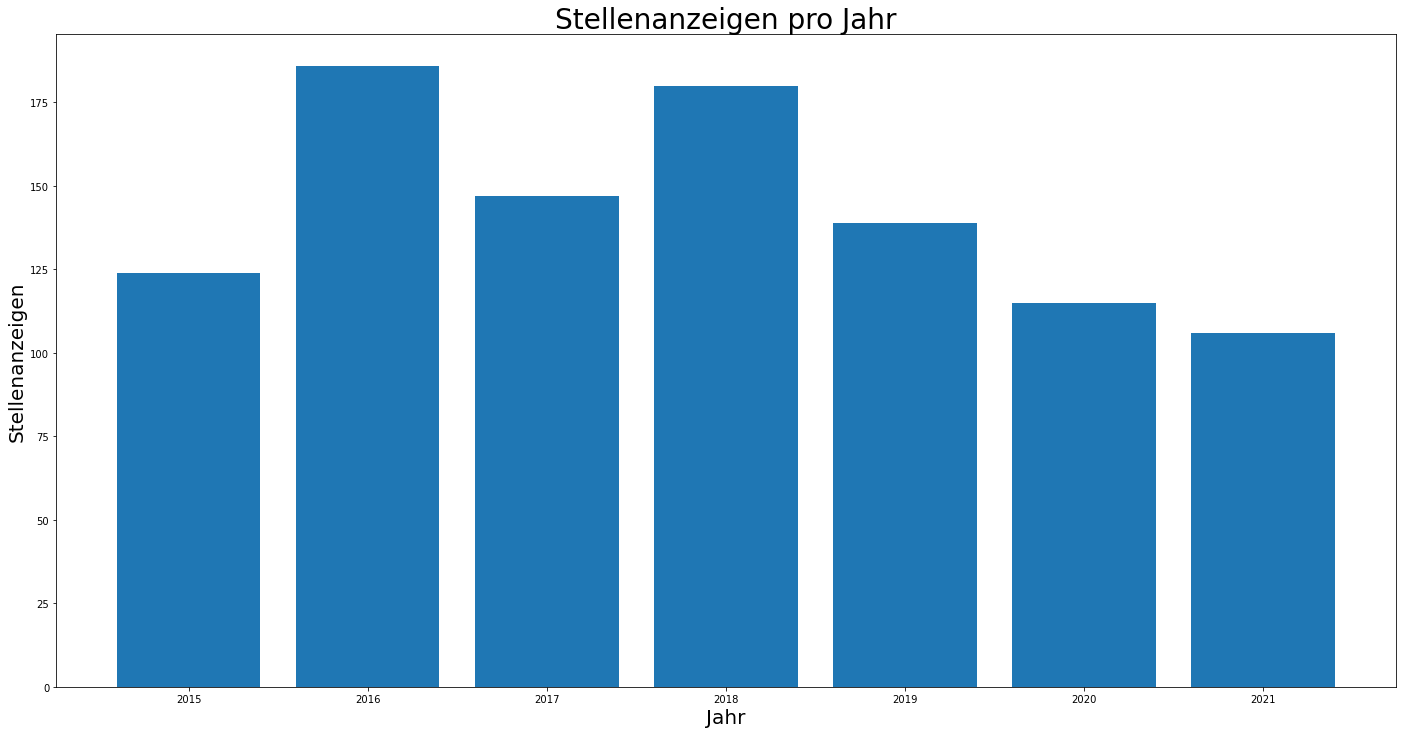

In [14]:
# Wie viele Stellenanzeigen sind pro Jahr erschienen?
startyear = 2015
endyear = 2022 # 2022 ist unvollständig, aber range-Objekt stoppt bei 2021

diagramm = {}

for year in range(startyear, endyear):
    anzahl = sum(ads_per_date[ads_per_date.index.year == year])
    diagramm[year] = anzahl

# Ausgabe als Diagramm
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(24)

plt.bar(diagramm.keys(), diagramm.values())
plt.title('Stellenanzeigen pro Jahr', fontsize=28)
plt.xlabel('Jahr', fontsize=20)
plt.ylabel('Stellenanzeigen', fontsize=20)
plt.style.use('ggplot')
plt.show()    

### Wie viele Stellenanzeigen sind pro Datum erschienen?

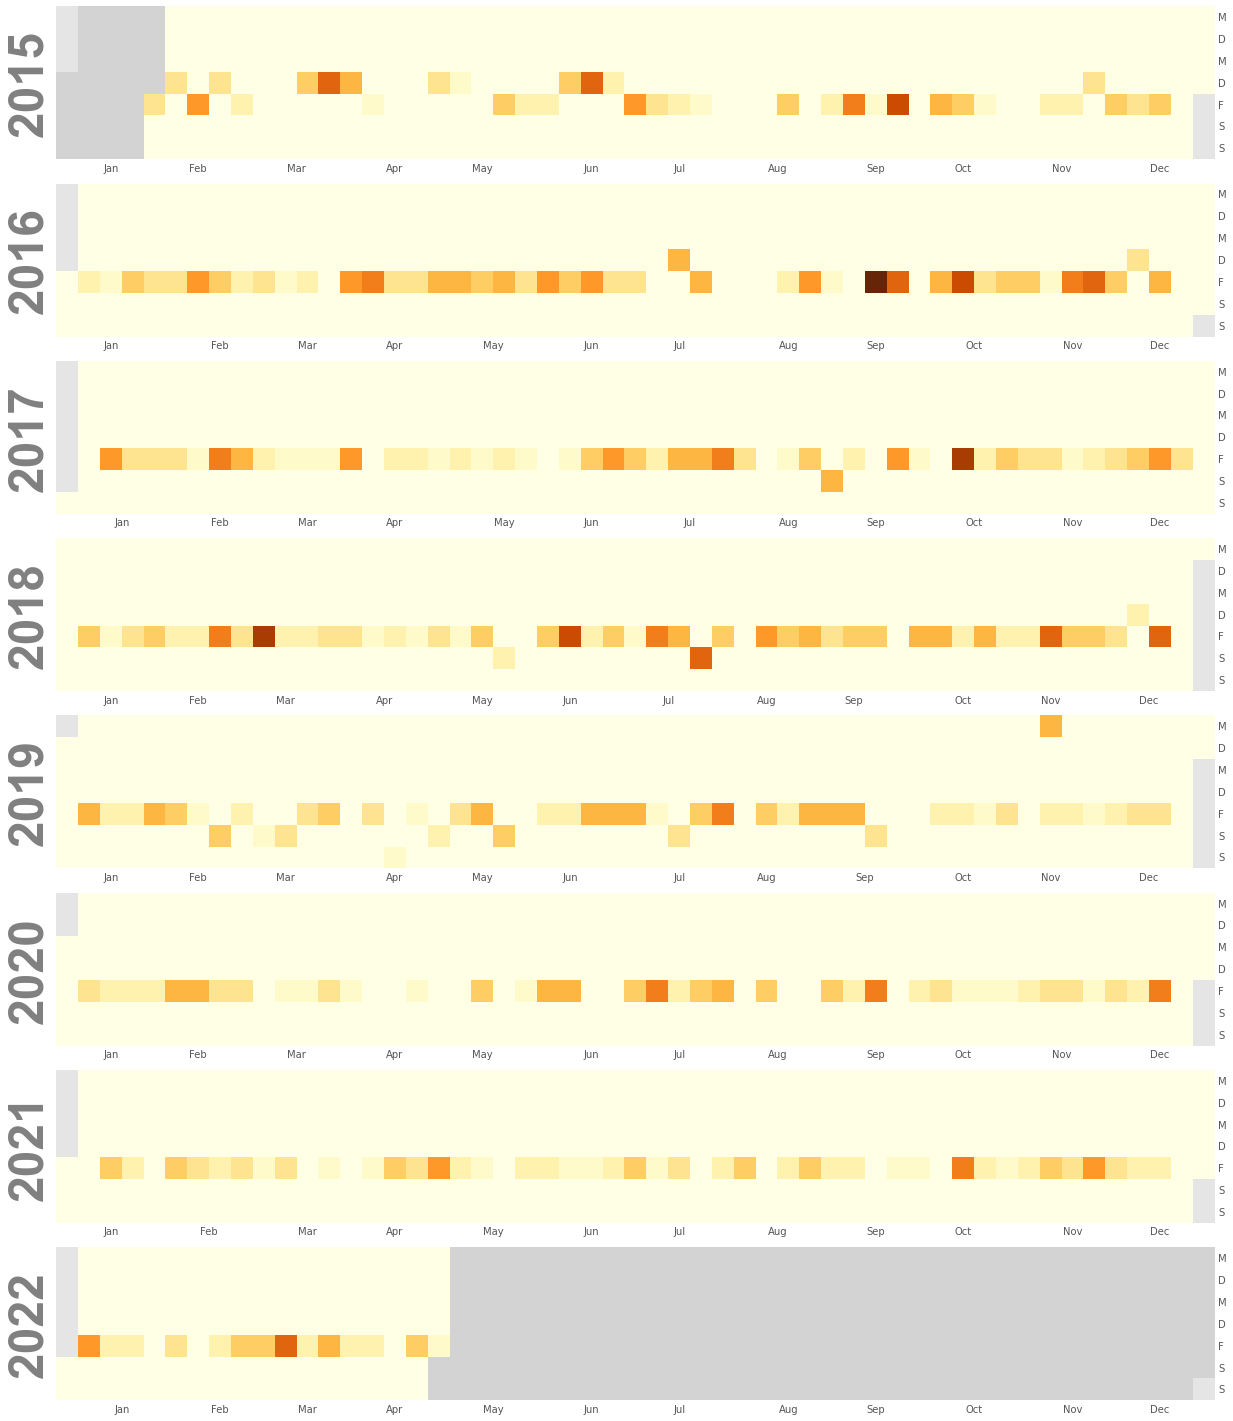

In [15]:
# Wie viele Stellenanzeigen sind pro Datum erschienen?
# Heatmap aller Stellenausschreibungen nach Datum
import calmap
import matplotlib.pyplot as plt

c = calmap.calendarplot(ads_per_date, monthticks=3, daylabels='MDMDFSS',
                    cmap='YlOrBr',
                    fillcolor='lightgrey', linewidth=0,
                    fig_kws=dict(figsize=(40, 20)),
                    yearlabel_kws={'color':'gray', 'fontsize':48})

## AUSWERTUNG: D-A-CH-BEREICH

### Welche Stellenanzeigen sind für Standorte D-A-CH-Bereich erschienen?

In [16]:
# ermittelt Stellenanzeigen im DACH-Bereich
# Filter für Stellenanzeigen im DACH-Bereich. Die Liste "staedte" wurde manuell ermittelt.

staedte = ['Aachen','Aalen','Ansbach','Babelsberg','Basel','Bayreuth','Berlin','Bern','Bielefeld','Bochum','Bonn',\
           'Braunschweig','Bremen','Bremerhaven','Chemnitz','Chur','Cottbus','Dresden','Düsseldorf','Erfurt','Erlangen',\
           'Essen','Flensburg','Frankfurt','Freiberg','Freiburg','Friedrichshafen','Gießen','Graz','Greifswald','Göttingen',\
           'Hagen','Halle','Halle-Wittenberg','Hamburg','Hannover','Heidelberg','Hildesheim','Innsbruck','Jena','Karlsruhe',\
           'Kassel','Kiel','Klagenfurt','Konstanz','Krems','Köln','Leipzig','Linz','Ludwigsburg','Luzern','Lüneburg',\
           'Magdeburg-Stendal','Mainz','Mannheim','Marburg','München','Münster','Oldenburg','Osnabrück','Paderborn','Passau',\
           'Pforzheim','Potsdam','Regensburg','Rostock','Saarbrücken','Salzburg','Siegen','Soest','Stuttgart','Trier',\
           'Tübingen','Vechta','Weimar','Wien','Witten/Herdecke','Wuppertal','Würzburg','Zürich']


In [17]:
# Funktion prüft, ob ein Wert aus staedte in Zeile vorhanden ist
# (Ist > 1 Wert vorhanden, wird nur der erste zurückgegeben!)
def common(staedte, row): 
    result = [stadt for stadt in staedte if re.search(stadt, row) is not None]
    if result == []:
        return None
    else:
        return result[0]

In [18]:
#  Fügt die Spalte "Standort" hinzu
stellenanzeigen['Standort'] = stellenanzeigen['Meldung'].apply(lambda row: common(staedte, row))

In [19]:
# filtert Standorte aus D-A-CH-Bereich
dach = stellenanzeigen.loc[stellenanzeigen.Standort.notna(), :].copy()
dach.reset_index(drop=True, inplace=True)

### Korrekturen

In [20]:
# Korrekturen

# Halle = Halle-Wittenberg
dach.loc[dach.Standort.str.contains('Halle'), 'Standort'] = 'Halle-Wittenberg'

# Frankfurt/Oder ist nicht Frankfurt/Main
dach.loc[dach.Meldung.str.contains('Frankfurt.*Oder'), 'Standort'] = 'Frankfurt (Oder)'

In [21]:
print(f'\nEs sind {len(dach)} Stellenanzeigen für den D-A-CH-Bereich erschienen.\n')


Es sind 769 Stellenanzeigen für den D-A-CH-Bereich erschienen.



### Liste (DataFrame) der D-A-CH-Stellenanzeigen

In [22]:
dach

,Datum,Meldung,Standort
0,2015-01-30,Wissenschaftliche/r Mitarbeiter/in an der Fakultät Medien der Bauhaus-Universität Weimar,Weimar
1,2015-01-30,Direktor/in des Internationalen Forschungszentrums Kulturwissenschaften in Wien,Wien
2,2015-01-30,Direktor Professur für Digital Humanities an der Universität Graz,Graz
3,2015-02-13,Wissenschaftliche/r Mitarbeiter/in an der Europa-Universität Flensburg,Flensburg
4,2015-02-13,Wissenschaftliche/r Mitarbeiter/in am Seminar für Medienbildung der Europa-Universität Flensburg,Flensburg
5,2015-02-13,Wissenschaftliche/r Mitarbeiter/in am Fachbereich Kommunikation und Medien der Hochschule Magdeburg-Stendal,Magdeburg-Stendal
6,2015-02-13,W2-Professur für Kommunikations- und Medienwissenschaft mit dem Schwerpunkt Kulturanalyse an der Universität Bremen,Bremen
7,2015-02-19,Referent/in für die Geschäftsstelle des Rates für Informationsinfrastrukturen an der Universität Göttingen,Göttingen
8,2015-02-19,Wissenschaftliche/r Mitarbeiter/in an der Leuphana Universität Lüneburg,Lüneburg
9,2015-02-19,Direktor/in des Internationalen Forschungszentrums Kulturwissenschaften in Wien,Wien


### Welche Standorte (D-A-CH) haben die meisten Stellenanzeigen veröffentlicht?

In [23]:
# Welche Standorte haben die meisten Stellenanzeigen veröffentlicht?
standorte_chart = dach.Standort.value_counts()
standorte_chart

Berlin               48
Bremen               36
Wien                 35
Potsdam              33
Siegen               33
Köln                 32
Bayreuth             26
Marburg              25
Lüneburg             24
Bochum               22
Flensburg            21
Paderborn            19
Freiburg             18
Zürich               17
Basel                16
Braunschweig         16
Weimar               15
Mainz                14
Passau               13
Leipzig              13
Düsseldorf           12
Bonn                 12
Karlsruhe            12
Innsbruck            11
Konstanz             10
Frankfurt            10
Linz                  9
Aachen                9
Tübingen              9
Halle-Wittenberg      9
Essen                 9
Hamburg               9
Hildesheim            8
Klagenfurt            8
Babelsberg            7
Oldenburg             7
Göttingen             7
Kassel                6
Hagen                 6
Krems                 6
Jena                  6
Dresden         

### Ausgabe als Pie Chart

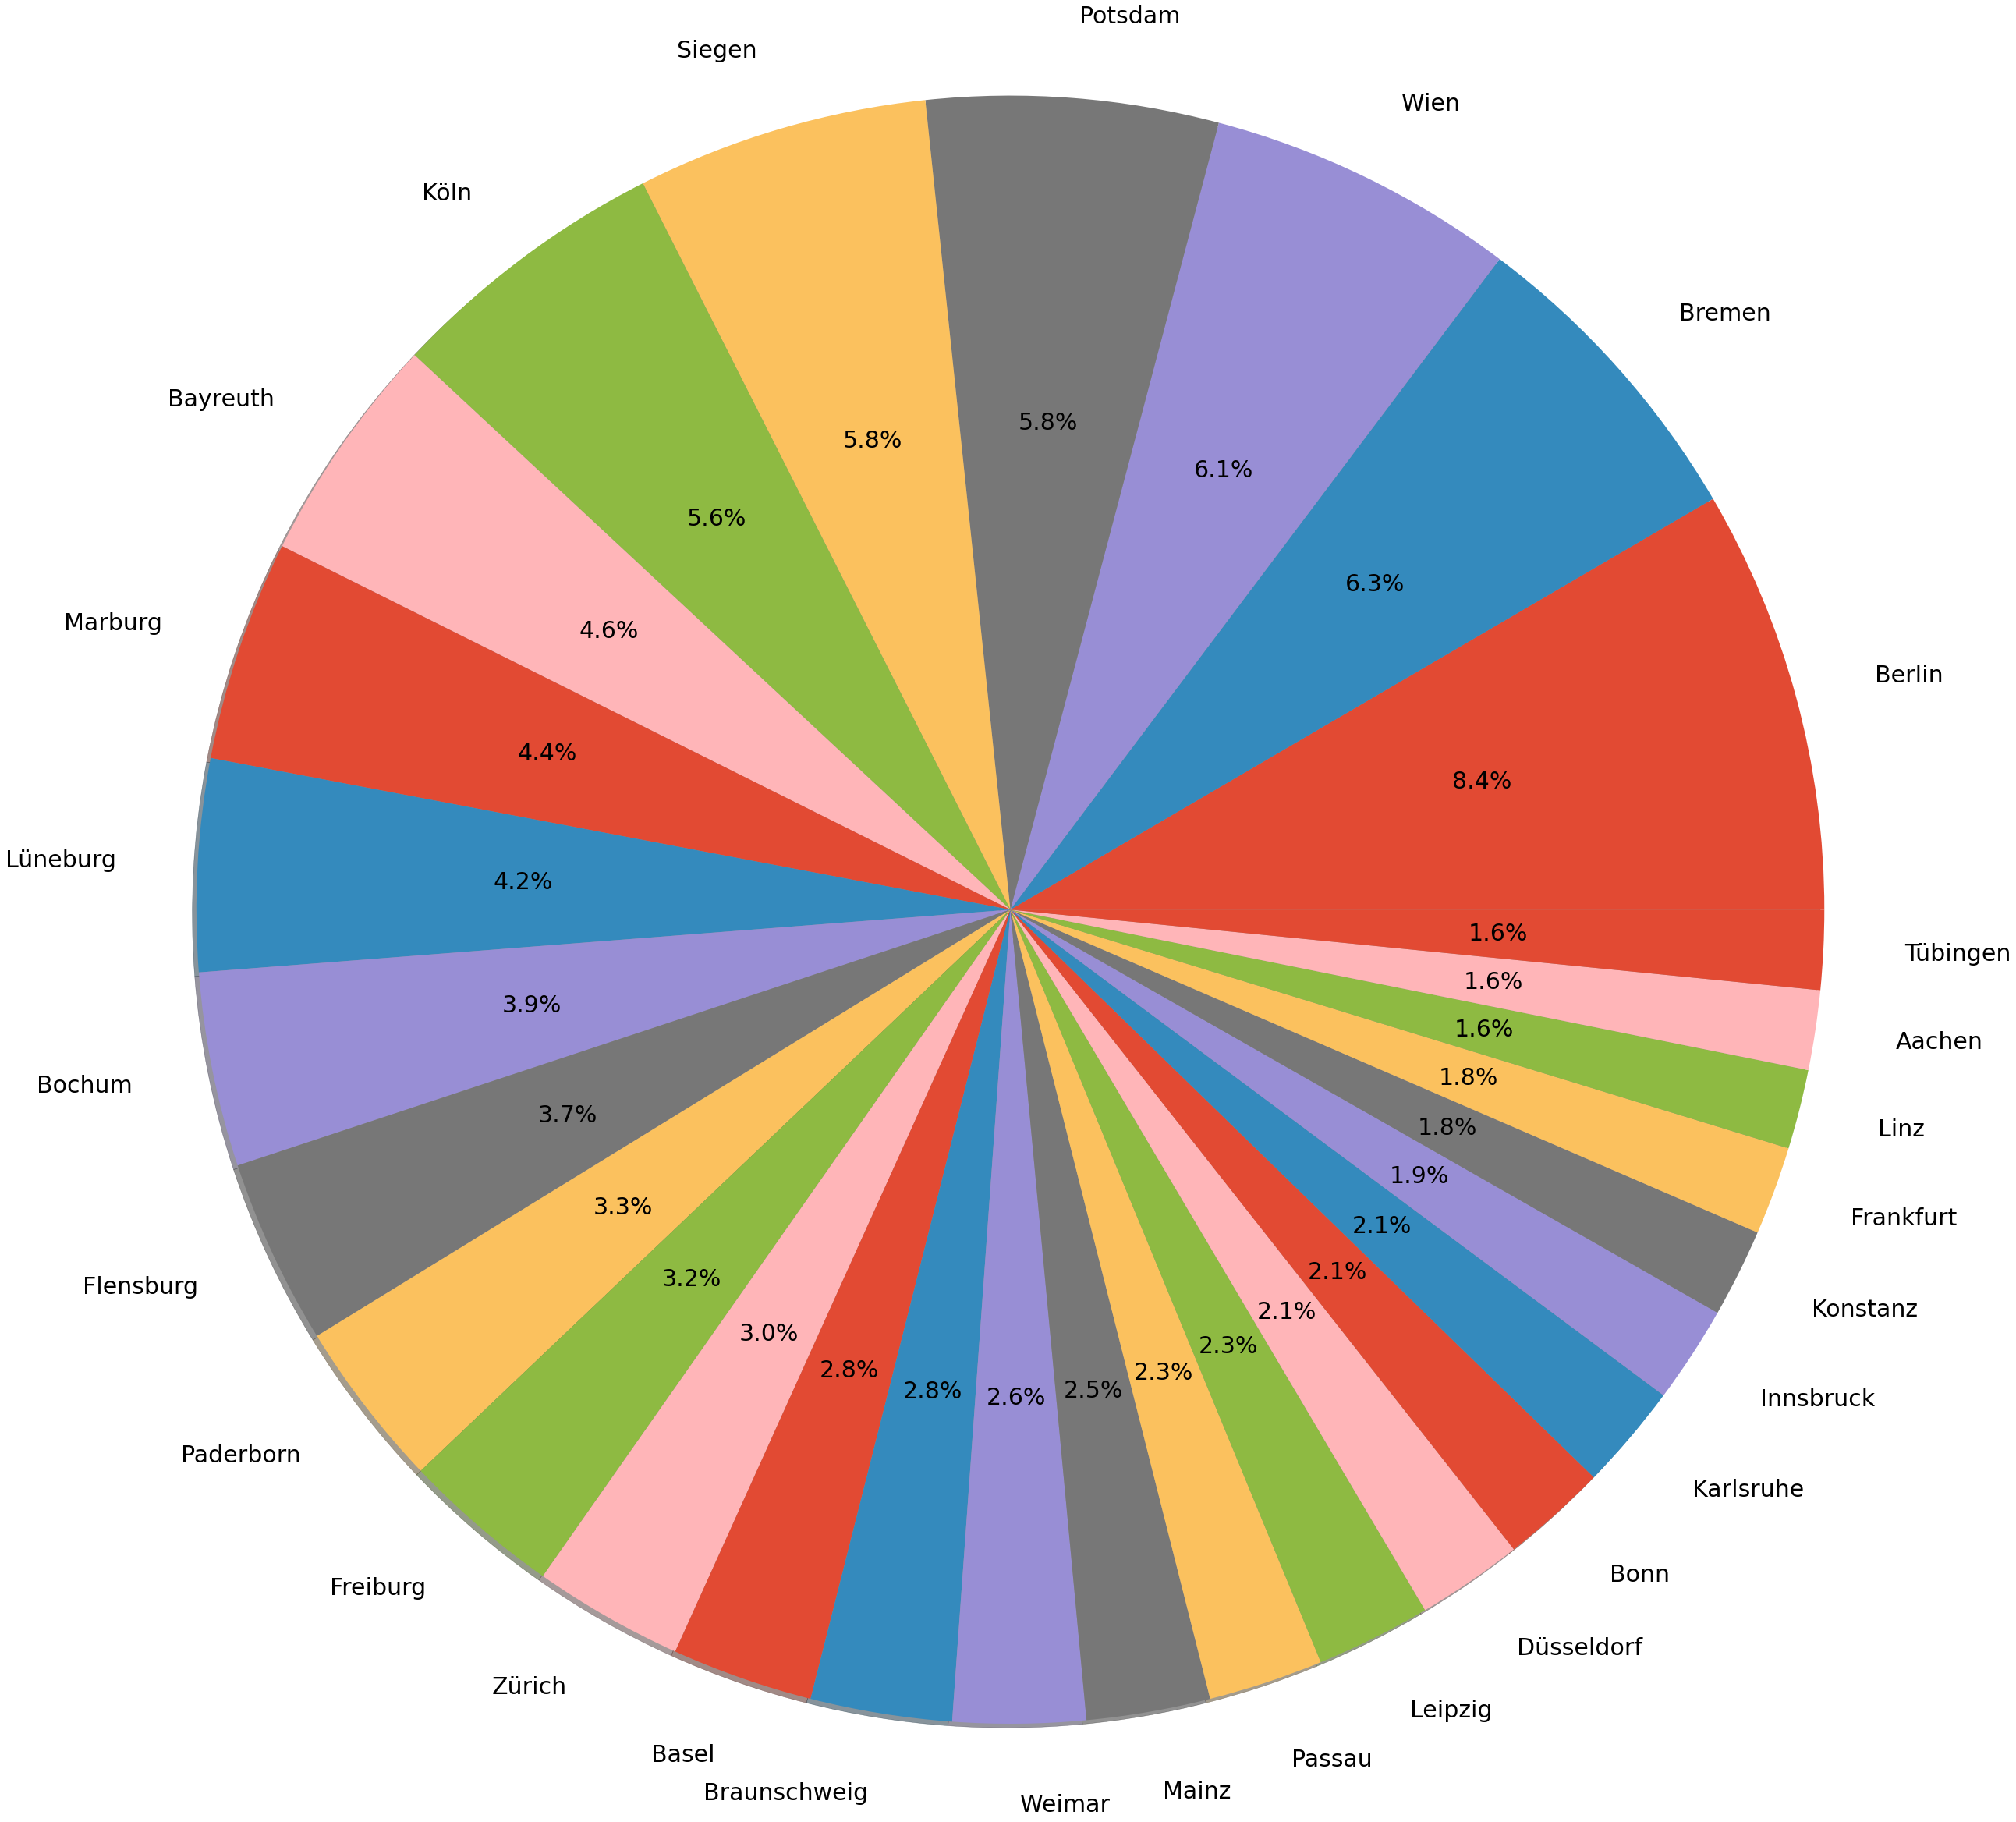

In [24]:
# Ausgabe: Pie Chart (TOP 30)
labels = standorte_chart.index[:29] # nur die ersten 30
sizes = standorte_chart[:29]

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(24)

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, radius=4, textprops={'fontsize': 30})
plt.show()

# AUSWERTUNG: STELLEN

### Definition Klasse "Stellen"

In [25]:
class Stellen:
    
    '''
    Die Klasse wertet Stellenanzeigen nach Jobtyp aus
    Suchbegriffe müssen im searchdict stehen
    '''
    
    searchdict = {
    'Juniorprofessur':'Juniorprofess.*|W1',
    'Professur':'[pP]rofess.*',
    'Mittelbau': '[aA]kad.* [Mit.*|Rat.*]|[Ww]iss.* Mit.*|[pP]ost-?[Dd]o[ck]|Promotion.*|Doktorand|lfba|Lehrkr[aä]ft|PhD'
    }
    
    def __init__(self, suchbegriff, df=dach):
        self.suchbegriff = suchbegriff
        self.pattern = self.searchdict[self.suchbegriff]
        self.stellen = df.loc[df.Meldung.str.contains(self.pattern)]
        self.anzahl  = len(self.stellen)
        
    
    def __repr__(self):
        return self.suchbegriff
    
    def anzahl_pro_jahr(self):
        print()
        diagramm = {}
        for year in range(2015, 2022):
            anzahl = len(self.stellen.loc[self.stellen['Datum'].dt.year == year])
            diagramm[year] = anzahl

            print(f'{year}: {anzahl} Stellenanzeigen für {self.suchbegriff}')

        print()

        # Ausgabe als Diagramm
        fig = plt.figure()
        fig.set_figheight(12)
        fig.set_figwidth(24)
        
        plt.bar(diagramm.keys(), diagramm.values())
        plt.title(f'Stellenanzeigen {self.suchbegriff}', fontsize=18)
        plt.xlabel('Jahr')
        plt.ylabel(f'{self.suchbegriff}')
        plt.style.use('ggplot')
        plt.show()

### Welche Stellenanzeigen sind für den **Mittelbau** erschienen?

In [26]:
# Filter: Stellenanzeigen für den Mittelbau
# Regex:  [aA]kad.* [Mit.*|Rat.*]|[Ww]iss.* Mit.*|[pP]ost-?[Dd]o[ck]|Promotion.*|Doktorand|lfba|Lehrkr[aä]ft
mittelbau = Stellen('Mittelbau')
mittelbau.stellen

,Datum,Meldung,Standort
0,2015-01-30,Wissenschaftliche/r Mitarbeiter/in an der Fakultät Medien der Bauhaus-Universität Weimar,Weimar
3,2015-02-13,Wissenschaftliche/r Mitarbeiter/in an der Europa-Universität Flensburg,Flensburg
4,2015-02-13,Wissenschaftliche/r Mitarbeiter/in am Seminar für Medienbildung der Europa-Universität Flensburg,Flensburg
5,2015-02-13,Wissenschaftliche/r Mitarbeiter/in am Fachbereich Kommunikation und Medien der Hochschule Magdeburg-Stendal,Magdeburg-Stendal
8,2015-02-19,Wissenschaftliche/r Mitarbeiter/in an der Leuphana Universität Lüneburg,Lüneburg
14,2015-03-19,"Wissenschaftliche/r Mitarbeiter am GRK 1769 ""Locating Media"" der Universität Siegen",Siegen
16,2015-03-26,Wissenschaftliche Mitarbeiter/innen an der Universität Siegen,Siegen
17,2015-03-26,Wissenschaftliche/r Mitarbeiter/in an der Universität Siegen,Siegen
21,2015-04-02,"Wissenschaftliche/r Mitarbeiter/in im Projekt ""History and Epistemology of the Problematic"" an der Leuphana Universität Lüneburg",Lüneburg
22,2015-04-02,"Wissenschaftliche/r Mitarbeiter/in im Projekt ""Sustainability thinking and the cybernetic imaginary"" an der Leuphana Universität Lüneburg",Lüneburg


### Wie viele Stellenanzeigen (Mittelbau) sind erschienen?

In [27]:
print(f' \
    \nVon {len(dach)} Stellenanzeigen im D-A-CH-Bereich waren {mittelbau.anzahl} für den Mittelbau ausgeschrieben.\n\
Das sind {mittelbau.anzahl/len(dach)*100:.2f} Prozent\n')

     
Von 769 Stellenanzeigen im D-A-CH-Bereich waren 377 für den Mittelbau ausgeschrieben.
Das sind 49.02 Prozent



### Verteilung der Stellenanzeigen (Mittelbau) 2015–2021


2015: 32 Stellenanzeigen für Mittelbau
2016: 54 Stellenanzeigen für Mittelbau
2017: 40 Stellenanzeigen für Mittelbau
2018: 52 Stellenanzeigen für Mittelbau
2019: 51 Stellenanzeigen für Mittelbau
2020: 57 Stellenanzeigen für Mittelbau
2021: 63 Stellenanzeigen für Mittelbau



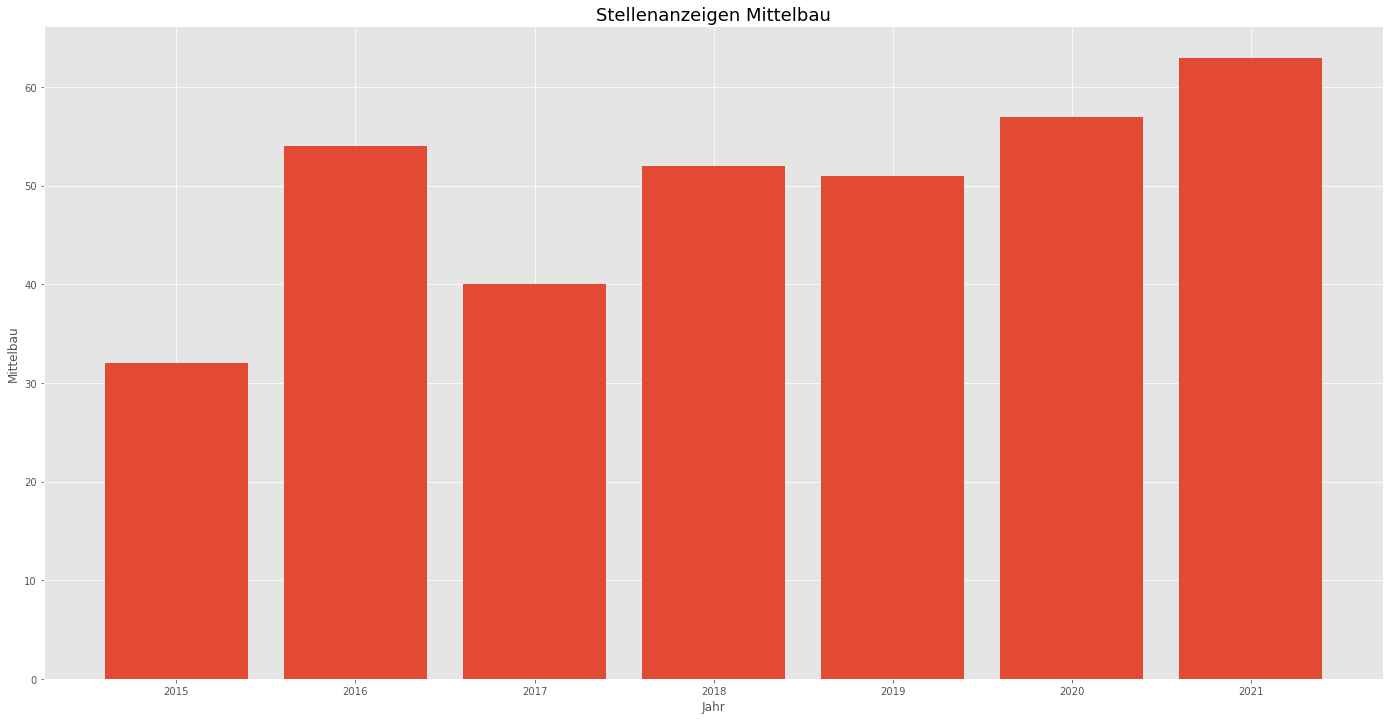

In [28]:
mittelbau.anzahl_pro_jahr()

### Welche Stellenanzeigen für **Professuren** sind erschienen?

In [29]:
# Filter ermittelt Stellenanzeigen für Professuren (inkl. Juniorprofessur)
professuren = Stellen('Professur')
professuren.stellen

,Datum,Meldung,Standort
2,2015-01-30,Direktor Professur für Digital Humanities an der Universität Graz,Graz
6,2015-02-13,W2-Professur für Kommunikations- und Medienwissenschaft mit dem Schwerpunkt Kulturanalyse an der Universität Bremen,Bremen
10,2015-02-27,W2-Professur für Medienökologie an der Universität Potsdam,Potsdam
13,2015-03-19,W2-Professur für Medienökologie an der Universität Potsdam,Potsdam
15,2015-03-26,W1-Juniorprofessur für Digitale Medienkultur an der Universität Leipzig,Leipzig
18,2015-03-26,Universitätsprofessur für Digital Humanities an der Universität Wien,Wien
19,2015-03-26,Universitätsprofessur für Kulturgeschichte audiovisueller Medien an der Universität Wien,Wien
20,2015-03-26,"W1-Professur für Medien, Kultur und Kommunikation an der Europa-Universität Viadrina Frankfurt (Oder)",Frankfurt (Oder)
24,2015-04-30,W3-Professur für Bildorientierte Medientechnologien / Technical Direction an der Filmuniversität Babelsberg,Babelsberg
30,2015-05-22,W2-Professur für Medienwissenschaft an der Universität Konstanz,Konstanz


### Wie viele Stellenanzeigen (Professur) sind erschienen?

In [30]:
print(f'\nVon {len(dach)} Stellenanzeigen im D-A-CH-Bereich waren {professuren.anzahl} als Professuren ausgeschrieben.\n\
Das sind {professuren.anzahl/len(dach)*100:.2f} Prozent\n')


Von 769 Stellenanzeigen im D-A-CH-Bereich waren 267 als Professuren ausgeschrieben.
Das sind 34.72 Prozent



### Verteilung der Stellenanzeigen (Professur) nach Jahren


2015: 20 Stellenanzeigen für Professur
2016: 54 Stellenanzeigen für Professur
2017: 31 Stellenanzeigen für Professur
2018: 69 Stellenanzeigen für Professur
2019: 40 Stellenanzeigen für Professur
2020: 26 Stellenanzeigen für Professur
2021: 21 Stellenanzeigen für Professur



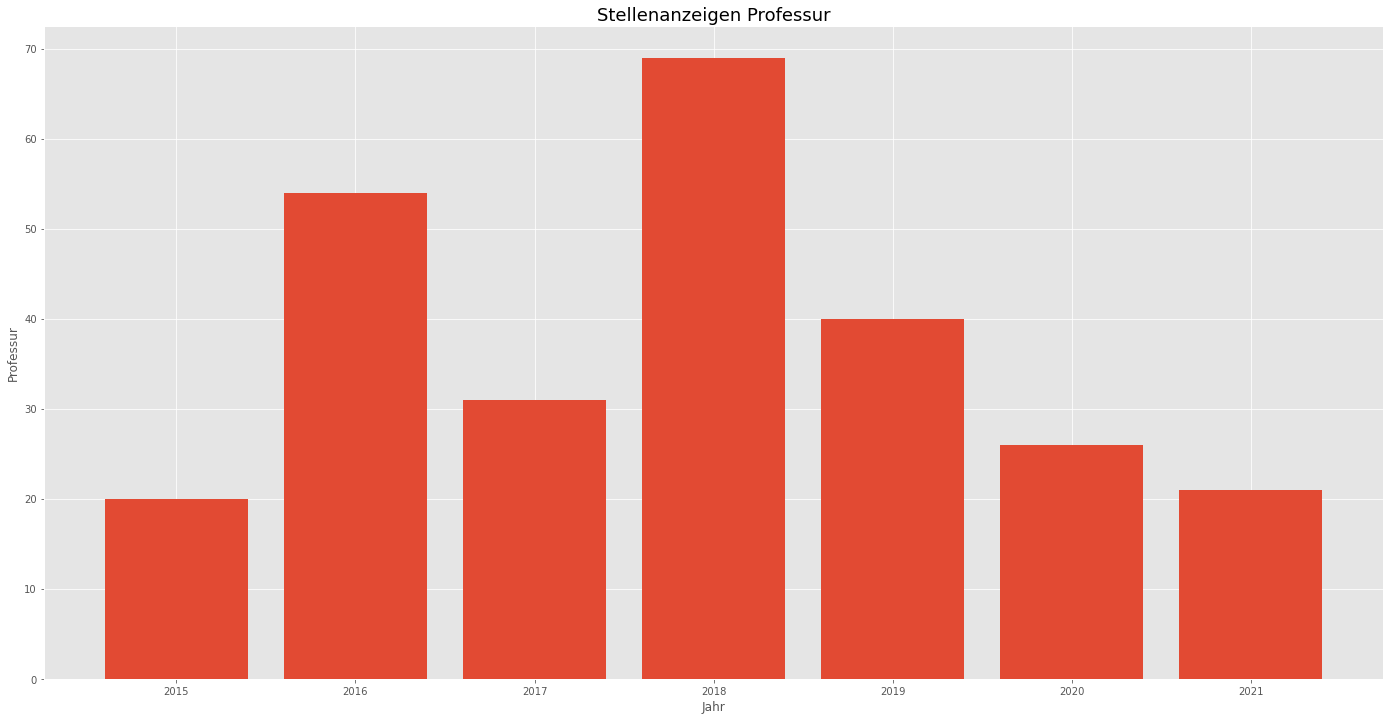

In [31]:
professuren.anzahl_pro_jahr()

### Welche Stellenanzeigen sind für **Juniorprofessuren** erschienen? 

In [32]:
# Filter ermittelt Stellenanzeigen für Juniorprofessuren
# pattern = 'Juniorprofess.*|W1'
junprof = Stellen('Juniorprofessur')
junprof.stellen

,Datum,Meldung,Standort
15,2015-03-26,W1-Juniorprofessur für Digitale Medienkultur an der Universität Leipzig,Leipzig
20,2015-03-26,"W1-Professur für Medien, Kultur und Kommunikation an der Europa-Universität Viadrina Frankfurt (Oder)",Frankfurt (Oder)
31,2015-05-29,W1-Professur für Bildtheorie Bauhaus-Universität Weimar,Weimar
50,2015-10-16,"Juniorprofessur (W 1) ohne Tenure Track für Geschichte und Geschichtsschreibung der technischen Bildmedien (Universität Köln, ab sofort)",Köln
53,2015-10-23,"W1-Juniorprofessur (50 %) für Medientheorie (München, zum 01.04.2016)",München
55,2015-11-13,"Juniorprofessur (W1, ohne Tenure Track) für Sound Studies (Köln, ab sofort)",Köln
75,2016-02-12,"Juniorprofessur: Europäische Ethnologie mit dem Schwerpunkt Medienanthropologie/Ethnographie neuer Medien (Berlin, zum 01.10.2016, Bewerbungsschluss: 10.03.2016)",Berlin
79,2016-02-19,"Juniorprofessur (W1) für Literatur- und Mediendidaktik (Münster, zum 01.10.2016, Bewerbungsschluss: 18.03.2016)",Münster
129,2016-06-24,"Juniorprofessur (W1) ""eHumanities"" (mit Tenure Track) (Halle-Wittenberg, ab sofort, Bewerbungsschluss: 15.08.2016)",Halle-Wittenberg
130,2016-07-01,"Juniorprofessur (W1) für Literatur- und medienwissenschaftliche Genderforschung (Hagen, ab sofort, Bewerbungsschluss: 14.08.2016)",Hagen


### Wie viele Stellenanzeigen (Juniorprofessur) sind erschienen?

In [33]:
anzahl1 = professuren.anzahl
anzahl2 = junprof.anzahl
print(f'\nVon {anzahl1} Stellenanzeigen für Professuren im D-A-CH-Bereich waren {anzahl2} als Juniorprofessuren/W1 ausgeschrieben.\n\
Das sind {anzahl2/anzahl1*100:.2f} Prozent\n')


Von 267 Stellenanzeigen für Professuren im D-A-CH-Bereich waren 64 als Juniorprofessuren/W1 ausgeschrieben.
Das sind 23.97 Prozent



### Verteilung der Stellenanzeigen (Juniorprofessur) nach Jahren


2015: 6 Stellenanzeigen für Juniorprofessur
2016: 11 Stellenanzeigen für Juniorprofessur
2017: 7 Stellenanzeigen für Juniorprofessur
2018: 19 Stellenanzeigen für Juniorprofessur
2019: 11 Stellenanzeigen für Juniorprofessur
2020: 5 Stellenanzeigen für Juniorprofessur
2021: 4 Stellenanzeigen für Juniorprofessur



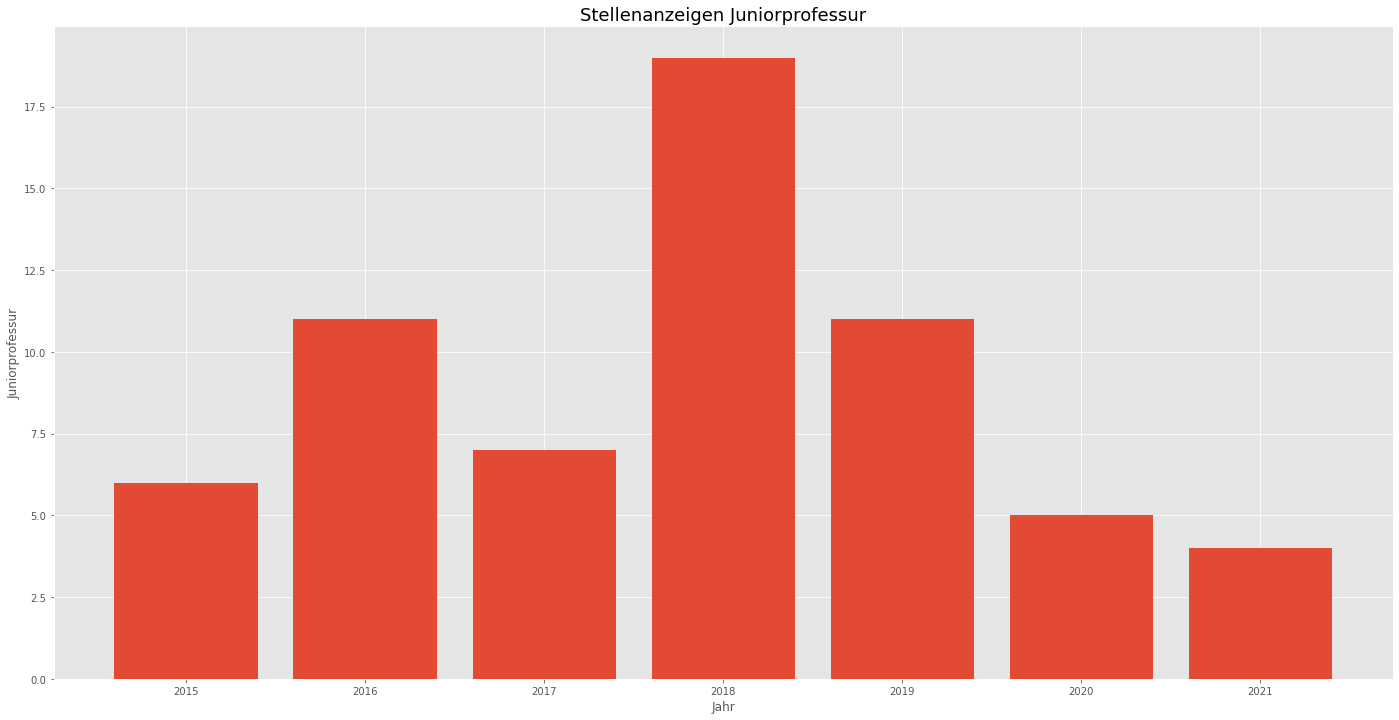

In [34]:
# Stellenanzeigen nach Jahren
junprof.anzahl_pro_jahr()

## Inhalte von Stellenanzeigen  
Die Funktion "Auswertung" durchsucht die D-A-CH-Stellenanzeigen nach beliebig wählbaren Schlagworten  
und gibt die TOP-20-Standorte zurück

In [35]:
# Funktion zur einfachen Auswertung von D-A-CH-Stellenanzeigen
def auswertung(pattern, df = dach):
    result = df.loc[df.Meldung.str.contains(pattern[1])]
    print(f'Es gibt {len(result)} Stellenanzeigen mit dem Stichwort \'{pattern[0]}\'\n')
    # TOP 20 der Standorte
    print(f"Die wichtigsten Standorte sind:\n\n{result.Standort.value_counts()[:20]}")

### Auswertung: Kunst / künstlerisch

In [36]:
pattern = ('Kunst/künstlerisch', '[Kk][uü]nst.*')
auswertung(pattern)

Es gibt 60 Stellenanzeigen mit dem Stichwort 'Kunst/künstlerisch'

Die wichtigsten Standorte sind:

Berlin          9
Köln            9
Karlsruhe       4
Oldenburg       3
Essen           3
Zürich          3
Bremen          3
Linz            3
Kassel          3
Leipzig         2
Krems           2
Luzern          2
Mainz           2
Bern            1
München         1
Wien            1
Braunschweig    1
Potsdam         1
Hamburg         1
Frankfurt       1
Name: Standort, dtype: int64


### Auswertung: Digital

In [37]:
pattern = ('digital', '[Dd]igital.*')
auswertung(pattern)

Es gibt 109 Stellenanzeigen mit dem Stichwort 'digital'

Die wichtigsten Standorte sind:

Passau             8
Berlin             7
Lüneburg           6
Wien               5
Flensburg          5
Bremen             4
Essen              3
Potsdam            3
Hamburg            3
Weimar             3
Wuppertal          3
Bayreuth           3
Köln               3
Krems              3
Innsbruck          3
Witten/Herdecke    3
Hagen              2
Zürich             2
Marburg            2
Mainz              2
Name: Standort, dtype: int64


### Auswertung: Film

In [38]:
pattern = ('Film', '[f|F]ilm.*')
auswertung(pattern)

Es gibt 71 Stellenanzeigen mit dem Stichwort 'Film'

Die wichtigsten Standorte sind:

Zürich         10
Potsdam         8
Mainz           8
Wien            7
Bremen          6
Babelsberg      5
Berlin          4
Frankfurt       4
Jena            3
Luzern          2
Hildesheim      2
Bonn            2
Passau          1
Marburg         1
Paderborn       1
Hamburg         1
Karlsruhe       1
Bremerhaven     1
Köln            1
Leipzig         1
Name: Standort, dtype: int64


### Auswertung: Fernsehen

In [39]:
pattern = ('Fernsehen', '[f|F]ernseh.*')
auswertung(pattern)

Es gibt 1 Stellenanzeigen mit dem Stichwort 'Fernsehen'

Die wichtigsten Standorte sind:

Mainz    1
Name: Standort, dtype: int64


### Auswertung: Games

In [40]:
pattern = ('Games', 'Game.*')
auswertung(pattern)

Es gibt 7 Stellenanzeigen mit dem Stichwort 'Games'

Die wichtigsten Standorte sind:

Bayreuth      3
Kassel        1
Würzburg      1
Stuttgart     1
Düsseldorf    1
Name: Standort, dtype: int64


In [41]:
pattern = ('Fotografie', '[F|Ph]otogra.*')
auswertung(pattern)

Es gibt 4 Stellenanzeigen mit dem Stichwort 'Fotografie'

Die wichtigsten Standorte sind:

Essen           2
Braunschweig    1
Bonn            1
Name: Standort, dtype: int64


### Vergleich von Stichworten

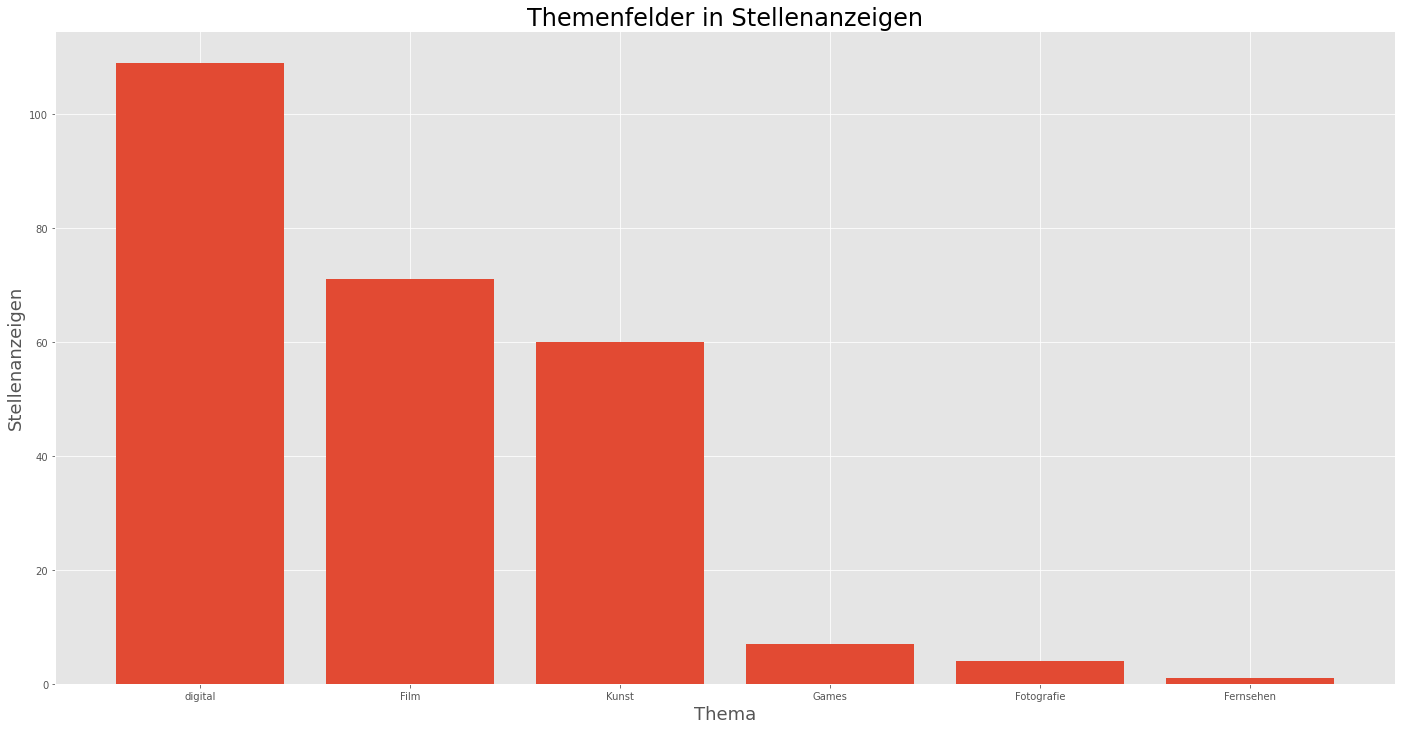

In [58]:
# Funktion zur einfachen Auswertung von D-A-CH-Stellenanzeigen
result = {}

pattern_list = [
    ('Fernsehen', '[f|F]ernseh.*'),
    ('Games', 'Game.*'),
    ('Film', '[f|F]ilm.*'),
    ('digital', '[Dd]igital.*'),
    ('Kunst', '[Kk][uü]nst.*'),
    ('Fotografie', '[F|Ph]otogra.*')
]

for pattern in pattern_list:
    anzahl = len(dach.loc[dach.Meldung.str.contains(pattern[1])])
    result[pattern[0]] = anzahl

result = dict(sorted(result.items(), key = lambda x: x[1], reverse=True))  # sortiert Ergebnis nach Werten 

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(24)
        
plt.bar(result.keys(), result.values())
plt.title('Themenfelder in Stellenanzeigen', fontsize=24)
plt.xlabel('Thema', fontsize=18)
plt.ylabel('Stellenanzeigen', fontsize=18)
plt.style.use('ggplot')
plt.show()

# AUSWERTUNG (II): Volltexte der STELLENANZEIGEN im Anhang

In [44]:
df = pandas.read_csv('./daten/stellenanzeigen_volltext.csv')

In [45]:
df.head(2)

Datum  \
0  2020-05-15   
1  2020-05-15   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Suche im Volltext nach 'befristet'

In [46]:
# Suche im Volltext nach 'befristet'
anzahl = len(df.loc[df.Stellenanzeige.str.contains(r'\bbefristet', regex=True), :])
print(f'Von allen {len(df)} Stellenanzeigen (im Anhang) enthalten {anzahl} den String \'befristet\'.\nDas sind {anzahl/len(df)*100:.2f} Prozent')

Von allen 990 Stellenanzeigen (im Anhang) enthalten 372 den String 'befristet'.
Das sind 37.58 Prozent


### Suche im Volltext nach 'unbefristet'

In [47]:
# Suche im Volltext nach 'unbefristet'
anzahl = len(df.loc[df.Stellenanzeige.str.contains(r'unbefristet'), :])
print(f'Von allen {len(df)} Stellenanzeigen (im Anhang) enthalten {anzahl} den String \'unbefristet\'.\nDas sind {anzahl/len(df)*100:.2f} Prozent')

Von allen 990 Stellenanzeigen (im Anhang) enthalten 78 den String 'unbefristet'.
Das sind 7.88 Prozent


### Suche im Volltext nach 'Teilzeit'

In [48]:
# Suche im Volltext nach 'Teilzeit'
anzahl = len(df.loc[df.Stellenanzeige.str.contains(r'Teilzeit'), :])
print(f'Von allen {len(df)} Stellenanzeigen (im Anhang) enthalten {anzahl} den String \'Teilzeit\'.\nDas sind {anzahl/len(df)*100:.2f} Prozent')

Von allen 990 Stellenanzeigen (im Anhang) enthalten 131 den String 'Teilzeit'.
Das sind 13.23 Prozent


### Suche im Volltext nach '%'

In [52]:
# Suche im Volltext nach 'prozentangabe (z.B. 50%, 65%, aber auch 100%)
anzahl = len(df.loc[df.Stellenanzeige.str.contains(r'\d\d\d?\s?%'), :])
print(f'Von allen {len(df)} Stellenanzeigen (im Anhang) enthalten {anzahl} eine Prozentangabe, sind also vermutlich Teilzeitstellen.\nDas sind {anzahl/len(df)*100:.2f} Prozent')

Von allen 990 Stellenanzeigen (im Anhang) enthalten 361 eine Prozentangabe, sind also vermutlich Teilzeitstellen.
Das sind 36.46 Prozent


# Analyse der Volltexte nach Themen

In [53]:
# analysiert ALLE Stellenanzeigen im Volltext (nicht nur D-A-CH), aber erst seit 10/2015

In [54]:
def analyse(pattern):
    return df.Stellenanzeige.loc[df.Stellenanzeige.str.contains(pattern)].__len__()

In [55]:
pattern_list = [
    'Cinema',
    'Film',
    'Kunst',
    'Art\s',
    'Comic',
    'Television',
    'Games',
    'Fernsehen'
]

for pattern in pattern_list:
    print(pattern, analyse(pattern))

Cinema 51
Film 300
Kunst 242
Art\s 74
Comic 3
Television 18
Games 11
Fernsehen 24
